---
title: "256 Data Cleaning"
---

运行本ipynb前，请确保各个dta文件在同一目录下。

In [13]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression
import warnings

# 忽略一些Pandas的切片警告
warnings.filterwarnings('ignore')

# do文件复现

In [20]:
# ==========================================
# 0. 基础工具函数 (您提供的)
# ==========================================
def clean_ids(df):
    """
    强制将合并键 (Merge Keys) 转换为标准字符串类型。
    这是解决 merge 结果为空的关键步骤。
    """
    keys = ['ssuid', 'shhadid', 'epppnum']
    for col in keys:
        if col in df.columns:
            # 1. 如果是 Categorical，先转回原始值
            if isinstance(df[col].dtype, pd.CategoricalDtype):
                df[col] = df[col].astype(object)
            # 2. 强制转为字符串，并去除可能的空格
            df[col] = df[col].astype(str).str.strip()
    return df

def load_stata(filename):
    """
    读取 Stata 文件并立即清洗主键。
    关键修正：convert_categoricals=False
    """
    try:
        # 核心修正：添加 convert_categoricals=False
        # 这样 eclwrk1 读进来是 1, 2... 而不是 "Private...", "Government..."
        df = pd.read_stata(filename, convert_categoricals=False)
        
        # 立即执行 ID 清洗
        df = clean_ids(df)
        
        print(f"Loaded {filename}: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None

# ==========================================
# 1. 预处理 Core (w) 文件: w7, w9
# ==========================================
print("\n--- Step 1: Processing Core Files (w7, w9) ---")

# 处理 w7
w7 = load_stata("w7.dta")
if w7 is not None:
    w7_v2 = w7[w7['srefmon'] == 4].copy()
    # 保留后续需要的列 (从 merge ... keepusing 推断)
    w7_cols = ['ssuid', 'shhadid', 'epppnum', 'tsjdate1', 'srotaton', 'wpfinwgt', 
               'eclwrk1', 'efnp', 'esex', 'tempall1', 'ejbind1']
    # 确保列存在再保留
    existing_cols = [c for c in w7_cols if c in w7_v2.columns]
    w7_v2 = w7_v2[existing_cols]

# 处理 w9
w9 = load_stata("w9.dta")
if w9 is not None:
    w9_v2 = w9[w9['srefmon'] == 4].copy()
    # 保留后续需要的列
    w9_cols = ['ssuid', 'shhadid', 'epppnum', 'tsjdate1'] # tsjdate1 needed for job retention check
    existing_cols = [c for c in w9_cols if c in w9_v2.columns]
    w9_v2 = w9_v2[existing_cols]



--- Step 1: Processing Core Files (w7, w9) ---
Loaded w7.dta: (311758, 908)
Loaded w9.dta: (302051, 931)


In [21]:

# ==========================================
# 2. 预处理 Topical (t) 文件: Rename & Prepare
# ==========================================
print("\n--- Step 2: Processing Topical Modules (t3, t6, t9, t12) ---")

waves = [3, 6, 9, 12]
t_dfs = {}

# 需要重命名的变量列表
vars_to_rename = [
    'taltb', 'thhintbk', 'thhintot', 'thhotast', 
    'thhira', 'thhscdbt', 'rhhuscbt', 'rhhstk', 
    'tcarval1', 'tcarval2', 'tcarval3'
]

for wave in waves:
    filename = f"t{wave}.dta"
    df = load_stata(filename)
    if df is not None:
        rename_dict = {var: f"{var}{wave}" for var in vars_to_rename if var in df.columns}
        df = df.rename(columns=rename_dict)
        # 只保留 ID 和重命名后的列 (加上 tage 等基础变量如果存在)
        cols_to_keep = ['ssuid', 'shhadid', 'epppnum'] + list(rename_dict.values())
        if wave == 6: # t6 还需要保留 tage, eeducate
             cols_to_keep += ['tage', 'eeducate']
        
        # 过滤只保留存在的列
        cols_to_keep = [c for c in cols_to_keep if c in df.columns]
        t_dfs[wave] = df[cols_to_keep]



--- Step 2: Processing Topical Modules (t3, t6, t9, t12) ---
Loaded t3.dta: (88755, 491)
Loaded t6.dta: (80245, 670)
Loaded t9.dta: (75523, 517)
Loaded t12.dta: (73257, 670)


In [22]:

# ==========================================
# 3. 主表合并 (Main Merge)
# ==========================================
print("\n--- Step 3: Main Merge ---")

# 以 t6 为基底 (Year 0 baseline)
main_df = t_dfs[6].copy()

# Merge t3, t9, t12
for wave in [3, 9, 12]:
    if wave in t_dfs:
        print(f"Merging t{wave}...")
        main_df = pd.merge(main_df, t_dfs[wave], on=['ssuid', 'shhadid', 'epppnum'], how='left')

# Merge t7 (Eligibility variables)
t7 = load_stata("t7.dta")
if t7 is not None:
    t7_cols = ['ssuid', 'shhadid', 'epppnum', 'enoina03', 'enoinb03', 'epensnyn', 
               'etdeffen', 'e1taxdef', 'e2taxdef', 'e3taxdef']
    t7_cols = [c for c in t7_cols if c in t7.columns]
    main_df = pd.merge(main_df, t7[t7_cols], on=['ssuid', 'shhadid', 'epppnum'], how='left')

# Merge w7_v2 (Demographics & Job Start)
if w7_v2 is not None:
    main_df = pd.merge(main_df, w7_v2, on=['ssuid', 'shhadid', 'epppnum'], how='left')



--- Step 3: Main Merge ---
Merging t3...
Merging t9...
Merging t12...
Loaded t7.dta: (77995, 618)


In [24]:

# ==========================================
# 4. 特征工程: 日期与资格 (Feature Engineering)
# ==========================================
print("\n--- Step 4: Job Dates and Eligibility Logic ---")

# 4.1 Create yr1jb1 (Is individual in first year of job?)
# Logic: tsjdate1 > Specific Date based on Rotation Group
# Note: tsjdate1 is likely numeric YYYYMMDD in Stata.
def check_yr1(row):
    try:
        date = float(row['tsjdate1'])
        rot = row['srotaton']
        if rot == 1: return date > 19970299
        elif rot == 2: return date > 19970399
        elif rot == 3: return date > 19970499
        elif rot == 4: return date > 19970599
        return False
    except:
        return False

main_df['yr1jb1'] = main_df.apply(check_yr1, axis=1).astype(int)

# 4.2 Calculate daysonjob
# Stata logic: year=int(tsjdate1/10000), etc.
# Target date is roughly April 1998 (adjusted by rotation)
def calc_days(row):
    try:
        tsj = int(row['tsjdate1'])
        year = tsj // 10000
        mo = (tsj - year * 10000) // 100
        day = tsj - year * 10000 - mo * 100
        
        rot = row['srotaton']
        # Base month logic from Stata loop
        base_mo_dict = {1: 3, 2: 4, 3: 5, 4: 6}
        base_mo = base_mo_dict.get(rot, 3)
        
        # Calculate days: ((1998 - year)*12 + base_mo - mo) * 30 + (30 - day)
        days = ((1998 - year) * 12 + base_mo - mo) * 30 + (30 - day)
        return days
    except:
        return np.nan

main_df['daysonjob'] = main_df.apply(calc_days, axis=1)

# 4.3 Create yr1v2 (At most 8 months by Wave 7) - for Table 5
def check_yr1v2(row):
    try:
        date = float(row['tsjdate1'])
        rot = row['srotaton']
        if rot == 1: return int(date > 19970699)
        if rot == 2: return int(date > 19970799)
        if rot == 3: return int(date > 19970899)
        if rot == 4: return int(date > 19970999)
        return 0
    except:
        return np.nan
main_df['yr1v2'] = main_df.apply(check_yr1v2, axis=1)



--- Step 4: Job Dates and Eligibility Logic ---


In [25]:

# ==========================================
# 5. 样本筛选 (Filtering)
# ==========================================
print("\n--- Step 5: Filtering Sample ---")
print(f"Before filter: {len(main_df)}")

# Keep if for-profit firm (eclwrk1 == 1)
main_df = main_df[main_df['eclwrk1'] == 1]

# Keep if age > 21 & age < 65
main_df = main_df[(main_df['tage'] > 21) & (main_df['tage'] < 65)]

print(f"After filter: {len(main_df)}")



--- Step 5: Filtering Sample ---
Before filter: 80245
After filter: 19908


In [26]:

# ==========================================
# 6. 资产变量加总 (Asset Aggregation)
# ==========================================
# Car values and Other assets
for w in [3, 6, 9, 12]:
    # Car value sum
    cols = [f'tcarval1{w}', f'tcarval2{w}', f'tcarval3{w}']
    # Fillna(0) ensures we can sum, but be careful if all are NaN. Stata treats sum of missings as missing usually?
    # Actually logic: gen tcarval3 = tcarval13 + ...
    main_df[f'tcarval{w}'] = main_df[cols].sum(axis=1, min_count=1) # min_count=1 ensures if all NaN, result NaN
    
    # Other assets sum
    other_cols = [f'thhintbk{w}', f'thhintot{w}', f'rhhstk{w}', f'thhotast{w}']
    main_df[f'otherassets{w}'] = main_df[other_cols].sum(axis=1, min_count=1)

In [27]:

# ==========================================
# 7. Merge Wave 9 Job Date (for Retention Check)
# ==========================================
# Stata: drop tsjdate1, merge w9v2
# In python we rename old tsjdate1 to avoid conflict, then merge
main_df = main_df.rename(columns={'tsjdate1': 'tsjdate1_w7'})

if w9_v2 is not None:
    w9_subset = w9_v2[['ssuid', 'shhadid', 'epppnum', 'tsjdate1']].rename(columns={'tsjdate1': 'tsjdate1_w9'})
    main_df = pd.merge(main_df, w9_subset, on=['ssuid', 'shhadid', 'epppnum'], how='left')

# Generate yr2jbdate (Did they stay on same job?)
def check_yr2jb(row):
    try:
        date = float(row['tsjdate1_w9'])
        rot = row['srotaton']
        if rot == 1: return date > 19980299
        if rot == 2: return date > 19980399
        if rot == 3: return date > 19980499
        if rot == 4: return date > 19980599
        return False
    except:
        return False # Missing or NaN

main_df['yr2jbdate'] = main_df.apply(check_yr2jb, axis=1).astype(int)


In [28]:

# ==========================================
# 8. Treatment Variable & Dummies
# ==========================================
# Education dummies
if 'eeducate' in main_df.columns:
    # Stata: tab eeducate, gen(educ)
    # Python: get_dummies
    educ_dummies = pd.get_dummies(main_df['eeducate'], prefix='educ', dummy_na=True)
    main_df = pd.concat([main_df, educ_dummies], axis=1)

# "temp" variable (Main Treatment)
# (enoina03==1 & etdeffen==1) | (enoinb03==1)
cond1 = (main_df['enoina03'] == 1) & (main_df['etdeffen'] == 1)
cond2 = (main_df['enoinb03'] == 1)
main_df['temp'] = (cond1 | cond2).astype(int)


In [29]:

# ==========================================
# 9. 收入加总 (Income Aggregation) - The "Efficient" Way
# ==========================================
print("\n--- Step 9: Aggregating Income (w7, w8, w9) ---")
income_dfs = []

# Load w7, w8, w9 raw files
for wave_name in ['w7', 'w8', 'w9']:
    fname = f"{wave_name}.dta"
    df_inc = load_stata(fname)
    if df_inc is not None:
        # Keep only income and IDs
        if 'thtotinc' in df_inc.columns:
            sub = df_inc[['ssuid', 'shhadid', 'epppnum', 'thtotinc']].copy()
            income_dfs.append(sub)

if income_dfs:
    all_income = pd.concat(income_dfs)
    # Sum by individual
    total_income = all_income.groupby(['ssuid', 'shhadid', 'epppnum'])['thtotinc'].sum().reset_index()
    total_income = total_income.rename(columns={'thtotinc': 'thtotincyr1'})
    
    # Merge back to main
    main_df = pd.merge(main_df, total_income, on=['ssuid', 'shhadid', 'epppnum'], how='left')
else:
    main_df['thtotincyr1'] = np.nan
    print("Warning: No income data found.")

# Missing income handling
main_df['incmissing'] = main_df['thtotincyr1'].isna().astype(int)
main_df['thtotincyr1'] = main_df['thtotincyr1'].fillna(-1)



--- Step 9: Aggregating Income (w7, w8, w9) ---
Loaded w7.dta: (311758, 908)
Loaded w8.dta: (307877, 908)
Loaded w9.dta: (302051, 931)


In [30]:

# ==========================================
# 10. 最终变量变换 (Final Transformations)
# ==========================================
print("\n--- Step 10: Generating Analysis Variables ---")

# Define variable list for transformation
vars_to_transform = ['taltb', 'thhira', 'otherassets', 'thhscdbt', 'rhhuscbt', 'tcarval']

for var in vars_to_transform:
    # 确保列存在 (比如 taltb12, taltb9, taltb6)
    v12 = main_df[f'{var}12']
    v9 = main_df[f'{var}9']
    v6 = main_df[f'{var}6']
    v3 = main_df[f'{var}3']
    
    # 1. Inverse Hyperbolic Sine (IHS) Diff
    # ln(x + sqrt(x^2+1)) is np.arcsinh(x)
    # Formula: IHS(12) - 2*IHS(9) + IHS(6)
    main_df[f'd21ihs{var}'] = np.arcsinh(v12) - 2*np.arcsinh(v9) + np.arcsinh(v6)
    
    # 2. Log Double Difference
    # ln(x + 10)
    l12 = np.log(v12 + 10)
    l9 = np.log(v9 + 10)
    l6 = np.log(v6 + 10)
    l3 = np.log(v3 + 10)
    
    main_df[f'd21l{var}'] = l12 - 2*l9 + l6
    main_df[f'd10l{var}'] = l9 - 2*l6 + l3 # for Table 5
    
    # 3. Interaction term
    main_df[f'temp{var}'] = main_df['temp'] * v6
    
    # 4. Winsorize
    # Stata winsor p(0.05) usually means trimming or capping top/bottom 5%
    # scipy winsorize replaces with cutoff value (which mimics Stata 'winsor')
    # Note: winsorize handles NaNs poorly, need to mask
    col_name = f'd21l{var}'
    mask = ~main_df[col_name].isna()
    data_to_winsor = main_df.loc[mask, col_name]
    if len(data_to_winsor) > 0:
        main_df.loc[mask, f'd21l{var}w'] = winsorize(data_to_winsor, limits=[0.05, 0.05])
    
    # 5. Log Levels
    main_df[f'l{var}9'] = l9
    main_df[f'l{var}6'] = l6

# Generate notmissing flag
# based on d21ltaltb not missing
main_df['notmissing'] = main_df['d21ltaltb'].notna().astype(int)



--- Step 10: Generating Analysis Variables ---


In [ ]:

# ==========================================
# 11. Universe & Clustering ID
# ==========================================
# y401k: Universe definition
# temp | e1taxdef==1 | e2taxdef==1 | e3taxdef==1 | (etdeffen==1 & yr1jb1)
cond_y401k = (
    (main_df['temp'] == 1) | 
    (main_df['e1taxdef'] == 1) | 
    (main_df['e2taxdef'] == 1) | 
    (main_df['e3taxdef'] == 1) | 
    ((main_df['etdeffen'] == 1) & (main_df['yr1jb1'] == 1))
)
main_df['y401k'] = cond_y401k.astype(int)

# Create Household ID (hid) for clustering
# ssuid + shhadid
main_df['hid_str'] = main_df['ssuid'] + "_" + main_df['shhadid']
main_df['hid'] = main_df.groupby('hid_str').ngroup()

# Age squared
main_df['tagesq'] = main_df['tage'] ** 2

# Industry dummies
if 'ejbind1' in main_df.columns:
    main_df['industry1digit'] = main_df['ejbind1'] // 100
    ind_dummies = pd.get_dummies(main_df['industry1digit'], prefix='ind1dig')
    main_df = pd.concat([main_df, ind_dummies], axis=1)

# Firm size dummies
if 'tempall1' in main_df.columns:
    size_dummies = pd.get_dummies(main_df['tempall1'], prefix='tempallnew')
    main_df = pd.concat([main_df, size_dummies], axis=1)

# ==========================================
# 12. Propensity Score (Logistic Regression)
# ==========================================
print("\n--- Step 12: Propensity Score Calculation ---")

# Define Covariates (as per dofile pscore command)
# pscore temp taltb3 ... tage ... educ* ...
# Note: Need to handle NaNs before Logistic Regression
ps_sample_mask = (main_df['y401k'] == 1) & (main_df['yr1jb1'] == 1)
df_ps = main_df[ps_sample_mask].copy()

# List of potential covariates (adjust based on created dummies)
# Need to find all educ columns, tempallnew columns, etc.
educ_cols = [c for c in main_df.columns if c.startswith('educ_')]
size_cols = [c for c in main_df.columns if c.startswith('tempallnew_')]
ind_cols = [c for c in main_df.columns if c.startswith('ind1dig_')]

base_covars = [
    'taltb3', 'thhira3', 'otherassets3', 'tcarval3', 'thhscdbt3', 'rhhuscbt3',
    'tage', 
    'taltb6', 'thhira6', 'otherassets6', 'tcarval6', 'thhscdbt6', 'rhhuscbt6',
    'efnp', 'esex', 'thtotincyr1', 'incmissing'
]
# Combine
covariates = base_covars + educ_cols + size_cols + ind_cols

# Cleaning for Logistic Regression
# Fill NaNs with 0 or mean (LogisticRegression throws error on NaN)
# Stata handles this by dropping missing, or if we want to keep, we fill.
# The do file says "notmissing" variable exists.
# We will drop rows with missing covariates for the PS calculation
X = df_ps[covariates].fillna(0) # Simplifying assumption for demo: fillna(0)
y = df_ps['temp']

if len(X) > 0:
    logit = LogisticRegression(max_iter=1000, solver='liblinear')
    logit.fit(X, y)
    main_df.loc[ps_sample_mask, 'ps'] = logit.predict_proba(X)[:, 1]
    print("Propensity Score calculated.")
else:
    print("Skipping PS Score: No data.")



--- Step 12: Propensity Score Calculation ---
Propensity Score calculated.

--- Process Complete ---
Final Data Shape: (19908, 162)


In [34]:
# ==========================================
# Final Cut: 锁定核心分析样本
# ==========================================

# 1. 筛选条件：必须是"新员工" (yr1jb1 == 1) 且 "公司有401k" (y401k == 1)
# 参考 Gelber (2011) p.106: "They must have started their current job one year or less before Wave 7"
# 参考 Gelber (2011) Table 2 Note: "sample includes all individuals... first year of employment... firm that offers a 401(k)"
analysis_df = main_df[
    (main_df['yr1jb1'] == 1) & 
    (main_df['y401k'] == 1) &
    (main_df['d21ltaltb'].notna())  # 确保结果变量不缺失 (Complete Case Analysis)
].copy()

print(f"原始样本量: {len(main_df)}")
print(f"最终分析样本量 (Analysis Sample): {len(analysis_df)}")

# 2. 再次检查 Treatment/Control 比例
print("\n最终样本分组情况:")
print(analysis_df['temp'].value_counts())

# 3. 保存这份最终数据给 Member C
analysis_df.to_csv("final_analysis_sample.csv", index=False)
print("\n文件已保存: final_analysis_sample.csv")

原始样本量: 19908
最终分析样本量 (Analysis Sample): 835

最终样本分组情况:
temp
0    539
1    296
Name: count, dtype: int64

文件已保存: final_analysis_sample.csv


# 数据可视化

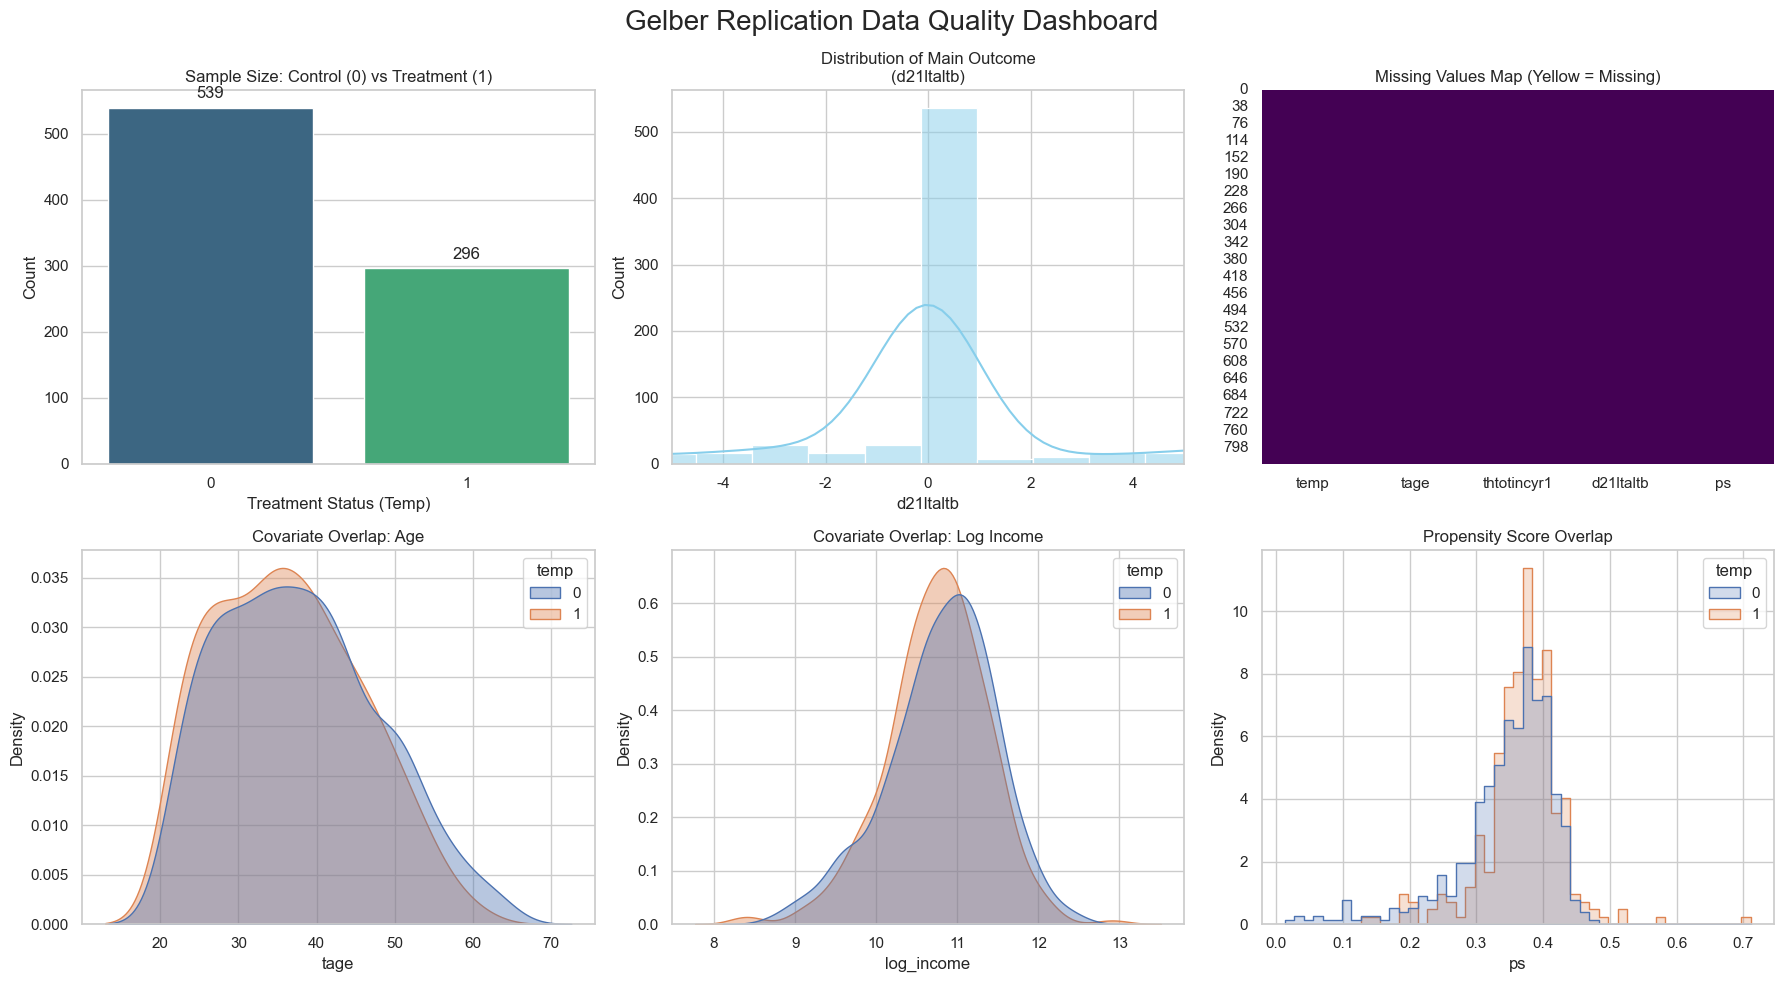

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 读取数据
df = pd.read_csv("final_analysis_sample.csv")

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams['axes.unicode_minus'] = False 

# 创建一个 2x3 的画布
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Gelber Replication Data Quality Dashboard', fontsize=20)

# --------------------------
# 图 1: 样本量分布 (Treatment vs Control)
# 检查：处理组 (Temp=1) 是否有足够的人数？
# --------------------------
sns.countplot(x='temp', data=df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Sample Size: Control (0) vs Treatment (1)')
axes[0, 0].set_xlabel('Treatment Status (Temp)')
axes[0, 0].set_ylabel('Count')
# 标上具体数值
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# --------------------------
# 图 2: 关键因变量分布 (Outcome Distribution)
# 检查：d21ltaltb (资产变化) 是否呈现正态分布？有没有极端离群值？
# --------------------------
# 这里我们对比 Winsorize 前后（如果生成了 d21ltaltbw）
target_col = 'd21ltaltb' 
if target_col in df.columns:
    sns.histplot(df[target_col].dropna(), kde=True, ax=axes[0, 1], color='skyblue', bins=30)
    axes[0, 1].set_title(f'Distribution of Main Outcome\n({target_col})')
    axes[0, 1].set_xlim(-5, 5) # 限制一下范围看核心区域
else:
    axes[0, 1].text(0.5, 0.5, 'Variable Not Found', ha='center')

# --------------------------
# 图 3: 缺失值热力图 (Missing Values Heatmap)
# 检查：是否有整列缺失？特别是关键的 covariates。
# --------------------------
# 选取部分关键列来检查
cols_to_check = ['temp', 'tage', 'thtotincyr1', 'educ_1.0', 'd21ltaltb', 'ps']
# 确保列存在
cols_existing = [c for c in cols_to_check if c in df.columns]
sns.heatmap(df[cols_existing].isnull(), cbar=False, ax=axes[0, 2], cmap='viridis')
axes[0, 2].set_title('Missing Values Map (Yellow = Missing)')

# --------------------------
# 图 4: 年龄分布重叠度 (Age Overlap)
# 检查：处理组和对照组的年龄分布是否重叠？(Positivity Check)
# Gelber 论文里说处理组通常更年轻，我们要验证这一点。
# --------------------------
sns.kdeplot(data=df, x='tage', hue='temp', fill=True, common_norm=False, alpha=0.4, ax=axes[1, 0])
axes[1, 0].set_title('Covariate Overlap: Age')

# --------------------------
# 图 5: 收入分布重叠度 (Income Overlap)
# 检查：收入分布是否重叠？注意收入是长尾分布，可能需要取对数看。
# --------------------------
# 为了绘图方便，排除负收入和0
plot_data = df[df['thtotincyr1'] > 0].copy()
plot_data['log_income'] = np.log(plot_data['thtotincyr1'])

sns.kdeplot(data=plot_data, x='log_income', hue='temp', fill=True, common_norm=False, alpha=0.4, ax=axes[1, 1])
axes[1, 1].set_title('Covariate Overlap: Log Income')

# --------------------------
# 图 6: 倾向得分分布 (Propensity Score Overlap)
# 检查：最核心的图！如果两个峰完全错开，PSM 就没法做了。
# --------------------------
if 'ps' in df.columns:
    sns.histplot(data=df, x='ps', hue='temp', element="step", stat="density", common_norm=False, ax=axes[1, 2])
    axes[1, 2].set_title('Propensity Score Overlap')
else:
    axes[1, 2].text(0.5, 0.5, 'PS Score Not Calculated', ha='center')

plt.tight_layout()
plt.show()

# 质量检查

In [46]:
# ==========================================
# Quality Check: Replicating Gelber Table 1
# ==========================================
import pandas as pd

# 确保使用的是筛选后的 df
df = analysis_df.copy()

# 定义要检查的变量 (根据论文 Table 1)
# 注意：论文里的 Assets 很多是 Wave 6 的值
cols_to_check = {
    'tage': 'Age',
    'thtotincyr1': 'Yearly Household Income',
    'taltb6': '401(k) Assets (Wave 6)',
    'thhira6': 'IRA Assets (Wave 6)',
    'otherassets6': 'Other Financial Assets', # 需确认是否是 Wave 6
    'thhscdbt6': 'Secured Debt',
    'tcarval6': 'Car Value'
}

# 分组计算均值 (Mean) 和 计数 (Count)
summary = df.groupby('temp')[list(cols_to_check.keys())].agg(['mean', 'std', 'count']).T

print(f"Total N: {len(df)}")
print("-" * 68)
print(f"{'Variable':<25} | {'Treatment (1) Mean':<15} | {'Control (0) Mean':<15} ")
print("-" * 68)

for col, name in cols_to_check.items():
    try:
        # 【修正点】：使用元组 (col, 'mean') 来定位 MultiIndex 的行
        # summary.loc[(变量名, 统计量), 组别]
        mean_0 = summary.loc[(col, 'mean'), 0]
        mean_1 = summary.loc[(col, 'mean'), 1]
        
        # 打印结果
        print(f"{name:<25} | {mean_1:>18,.1f} | {mean_0:>18,.1f}")        
    except KeyError as e:
        print(f"Skip {name}: {e}")

print("-" * 68)
# 【修正点】：计数同理，定位 (col, 'count')
try:
    n_0 = int(summary.loc[('tage', 'count'), 0])
    n_1 = int(summary.loc[('tage', 'count'), 1])
    print(f"{'Sample Size (N)':<25} | {n_1:>18} | {n_0:>18}")
except:
    print("Sample size check failed")


Total N: 835
--------------------------------------------------------------------
Variable                  | Treatment (1) Mean | Control (0) Mean 
--------------------------------------------------------------------
Age                       |               36.3 |               37.8
Yearly Household Income   |           55,927.1 |           60,446.9
401(k) Assets (Wave 6)    |            4,363.1 |            6,998.0
IRA Assets (Wave 6)       |            6,467.8 |            7,907.7
Other Financial Assets    |           18,504.9 |           48,575.4
Secured Debt              |           56,798.3 |           62,502.4
Car Value                 |           11,151.3 |           12,249.6
--------------------------------------------------------------------
Sample Size (N)           |                296 |                539


G老师提供的原始论文参考对比

|检查项目|Treatment (1) 预期值|Control (0) 预期值|说明|
|---|---|---|---|
|人数 (N)|~296|~539|如果你的分布是 296 vs 539，那就是神级复现。|
|年龄 (Age)|35.7|37.5|处理组应该更年轻。|
|收入 (Income)|"56,658.9"|"62,519.2"|处理组收入略低。|
|401(k)资产|"4,132.5"|"7,118.2"|差距应该很大（因为处理组没资格存钱）。|
|IRA 资产|"7,464.3"|"8,042.8"|两组的 IRA 应该差不多（这是关键假设）。|